# Surplux Solar Energy

## Import Package

In [1]:
import os
import math
import random
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Helper Functions
Before we write the code for adjusting the models, lets define a few helper functions.

In [3]:
# Get the station ID of the recent station measurement
def get_recent_station(lon, lat, stations):
    distances = list(stations.apply(lambda station: get_geodistance(lon, lat, station['Lon'], station['Lat']), axis=1))
    return distances.index(min(distances))
# Calculate distance based on latitude and longitude
def get_geodistance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * \
        math.cos(lat2) * math.sin(dlon/2)**2
    distance = 2*math.asin(math.sqrt(a))*6371*1000
    return distance

In [4]:
# group by lon
def group_by_lon(df):
    return df.groupby(['Lon']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lon'], ascending=False, ignore_index=True)
def filter_by_lon(df, lon):
    return df[df['Lon'].eq(lon)]

# group by lat
def group_by_lat(df):
    return df.groupby(['Lat']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat'], ascending=False, ignore_index=True)
# filter by lat
def filter_by_lat(df, lat):
    return df[df['Lat'].eq(lat)]

# group by location
def group_by_location(df):
    return df.groupby(['Lat', 'Lon']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# filter by location
def filter_by_location(df, lat, lon):
    return df[df['Lat'].eq(lat) & df['Lon'].eq(lon)]

# group by module & capacity & location
def group_by_module_capacity_location(df):
    return df.groupby(['Module', 'Lat', 'Lon', 'Capacity']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# filter by module & capacity & location
def filter_by_module_capacity_location(df, module, capacity, lat, lon):
    return df[df['Lat'].eq(lat) & df['Lon'].eq(lon) & df['Module'].eq(module) & df['Capacity'].eq(capacity)]


In [5]:
# Day of Year & Day of Year (Transformed)
def data_preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    # data['DayOfYear'] = data['Date'].dt.dayofyear/366
    # data['DayOfYearTransformed'] = data['Date'].dt.dayofyear.apply(transform_day_of_year)
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6
    # data['Irradiance_m'] = data['Irradiance_m'] / 1000
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    data['CapacityFactor'] = data['Generation']/data['Capacity']
    # Array Ratio compares the energy collected through the system to the total system load by dividing energy in by energy-out. 
    # data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']
    # data['ArrayRatio_m'] = data['CapacityFactor']/data['Irradiance_m']
    data = data.rename(columns={'Generation': 'Generation(kWd)', 'Irradiance': 'Irradiance(kWd/m2)'})
    return data

In [6]:
from pvlib.location import Location
def get_clear_sky_irradiance(lon, lat, start, end):
    # Clearsky must be get in the same timezone as the location, because the clearsky model is timezone-dependent.
    location = Location(lat, lon, 'Asia/Taipei')
    # Clearsky must be get in a date range.
    times = pd.date_range(start=start, end=end + datetime.timedelta(days=1), freq='1h', tz=location.tz)
    data = location.get_clearsky(times).reset_index()
    data['Datetime'] = pd.to_datetime(data['index']).dt.tz_localize(None)
    # 1 kW = 1000 W 
    data['ClearSkyIrradiance(kWh/m2)'] = data['ghi']/1000
    return data[['Datetime', 'ClearSkyIrradiance(kWh/m2)']]

In [7]:
def get_cwb_observation(stationID):
    def remove_str(x):
        try: return float(x)
        except: return np.nan
    # Read observation data from local file, you need to grab those files from the website first.
    data = pd.read_csv(os.path.join(path, f'data/observation(cwb)/{stationID}.csv'))
    # Remove the special word of each attribute, such as 'T', 'x', 'V', '/', ...
    for column in data.columns[5:]:
        data[column] = data[column].apply(lambda x: remove_str(x))
    # 1 kwh = 3.6 mj
    # 1 MJ to kwh = 0.27778 kwh
    data['GloblRad'] = data['GloblRad'].astype(float) / 3.6
    # Time format conversion: ObStime is 1 ~ 24, and should be adjusted to 0 ~ 23
    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + (data['ObsTime']-1).astype(str) + ':00:00')
    data = data.rename(columns={"GloblRad": "Irradiance(kWh/m2)"})
    return data[['Datetime', 'Irradiance(kWh/m2)', 'SunShine', 'Temperature', 'RH', 'WS', 'Precp', 'PrecpHour', 'Cloud Amount']]

In [8]:
def transform_day_of_year(day_of_year):
    """transform day_of_year through winter solstice and summer solstice.

    summer solstice = 173, winter solstice = 356.

    Args:
        day_of_year(int): day of year. (1 to 366)

    Returns:
        int: day of year been transformed. (0.0 to 1.0)
    """

    if(day_of_year > 356):
        return (day_of_year-356)/((173+366)-356)
    elif(day_of_year < 173):
        return (day_of_year+366-356)/((173+366)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [9]:
# linear interpolation
from scipy.interpolate import interp1d
def interpolate(x, kind='linear'):
    not_nan = np.logical_not(np.isnan(x))
    indices = np.arange(len(x))
    interp = interp1d(indices[not_nan], x[not_nan], kind=kind)
    # interp = interp1d(indices[not_nan], x[not_nan], kind=kind, fill_value="extrapolate")
    # interp = interp1d(indices[not_nan], x[not_nan], kind=kind, bounds_error=False, fill_value=np.nan)
    return interp(indices)

In [10]:
# evaluate
def RMSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) ** 2).mean())

## Const & Inputs
Here are all of the parameters to change for the run.

In [11]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

In [12]:
outliers = [
    {
        'irradiance': [],
        'generation': ['2021-09-10', '2021-09-21', '2021-09-23']
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-01-28', '2021-05-14']
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-05-14']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-03-07']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2021-08-04'],
        'generation': ['2021-07-19']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
]

## Data Preprocessing: Load Data

In [13]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train = train.drop(['Irradiance_m', 'Temp_m', 'Temp'], axis=1)
train = train.dropna(axis=0)
train.insert(0, 'Set', 'train')
train.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,CapacityFactor
count,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000
mean,1800.654494,1341.022191,4.796601,350.021034,24.480935,120.757309,-20.473837,3.895972
std,1033.142458,797.035683,1.894333,144.511213,0.482053,0.347354,52.814505,1.535221
min,1.000000,17.000000,0.036111,99.200000,24.040000,120.440000,-160.000000,0.117695
25%,914.750000,575.000000,3.658333,246.400000,24.080000,120.470000,-31.000000,3.015508
50%,1804.500000,1269.000000,5.213889,352.000000,24.107000,120.520000,1.760000,4.294109
75%,2694.250000,1959.000000,6.247917,498.560000,25.030000,121.080000,4.630000,5.046574
max,3584.000000,6752.000000,8.005556,499.800000,25.110000,121.260000,22.000000,21.443089


In [14]:
train_group = group_by_module_capacity_location(train)
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    outliers2 = train_idf[train_idf['Date'].isin(pd.to_datetime(outliers[i]['generation']).date)].index.tolist()
    train = train[~(train.index.isin(outliers2))].reset_index(drop=True)

In [15]:
test = pd.read_csv(os.path.join(path, 'data/test.csv'))
test = data_preprocessing(test)
test = test.drop(['Irradiance_m', 'Temp_m', 'Temp'], axis=1)
test.insert(0, 'Set', 'test')
test.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,CapacityFactor
count,1539.000000,0.0,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,0.0
mean,770.000000,NaN,3.378431,335.654321,24.358381,120.680032,-17.387479,NaN
std,444.415346,NaN,1.399051,132.486180,0.444123,0.309303,47.846896,NaN
min,1.000000,NaN,0.261111,99.200000,24.040000,120.440000,-160.000000,NaN
25%,385.500000,NaN,2.277778,267.520000,24.070000,120.470000,-2.620000,NaN
50%,770.000000,NaN,3.866667,314.880000,24.080000,120.520000,0.000000,NaN
75%,1154.500000,NaN,4.525000,492.800000,24.980000,121.030000,4.630000,NaN
max,1539.000000,NaN,5.611111,499.800000,25.110000,121.260000,22.000000,NaN


In [16]:
stations = pd.read_csv(os.path.join(path, 'data/cwb_meta.csv'))
stations = stations[stations['StationID'].str.contains("^46")].reset_index(drop=True)
stations = stations[pd.to_datetime(stations['StartDate']) <= pd.to_datetime(train['Date'].min())].reset_index(drop=True)
stations.head(3)

,StationID,StationName,Altitude,City,Lon,Lat,Address,StartDate
0,466850,五分山雷達站,756.0,新北市,121.781205,25.071182,瑞芳區靜安路四段1巷1號,1988-07-01
1,466880,板橋,9.7,新北市,121.442017,24.997647,板橋區大觀路二段265巷62號,2002-01-01
2,466900,淡水,19.0,新北市,121.448906,25.164889,淡水區中正東路42巷6號,1942-10-01


In [17]:
train_group = group_by_module_capacity_location(train)
train_group['StationID'] = train_group.apply(lambda row: stations['StationID'][get_recent_station(row['Lon'], row['Lat'], stations)], axis=1)
train_group['StationID'].unique()

array(['466900', '467050', '467770', '467490', '467270'], dtype=object)

## Data Preprocessing: Day to Hour

Check the start date and end date of both train and test data.

In [18]:
date_range = pd.DataFrame(columns=['Filter', 'TrainStartDate', 'TrainEndDate', 'TestStartDate', 'TestEndDate'])
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    date_range.loc[i] = [f"{row['Module']}({row['Capacity']})", train_idf['Date'].min(), train_idf['Date'].max(), test_idf['Date'].min(), test_idf['Date'].max()]
date_range

,Filter,TrainStartDate,TrainEndDate,TestStartDate,TestEndDate
0,MM60-6RT-300(438.3),2020-12-14,2021-10-28,2021-10-29,2022-02-17
1,MM60-6RT-300(499.8),2020-06-09,2021-10-28,2021-10-29,2022-02-17
2,MM60-6RT-300(498.6),2020-12-17,2021-10-28,2021-10-29,2022-02-17
3,SEC-6M-60A-295(283.2),2020-12-17,2021-10-28,2021-10-29,2022-02-17
4,AUO PM060MW3 320W(246.4),2020-09-24,2021-10-28,2021-10-29,2022-02-16
5,AUO PM060MW3 320W(492.8),2020-09-23,2021-10-28,2021-10-29,2022-02-16
6,AUO PM060MW3 320W(278.4),2021-05-21,2021-10-28,2021-10-29,2022-02-16
7,AUO PM060MW3 320W(267.52),2021-05-21,2021-10-28,2021-10-29,2022-02-16
8,AUO PM060MW3 325W(343.2),2021-10-09,2021-10-28,2021-10-29,2022-02-16
9,AUO PM060MW3 320W(99.2),2020-09-27,2021-10-28,2021-10-29,2022-02-16


Because train and test data have time coherent, we can merge them first when we make preprocessing.

In [19]:
full = pd.concat([train, test], axis=0)
full = full.sort_values(by=['Date', 'ID'], ignore_index=True)
full.tail(5)

,Set,ID,Date,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,Module,CapacityFactor
5083,test,1535,2022-02-16,NaN,5.600000,343.2,24.08,120.52,-2.62,AUO PM060MW3 325W,NaN
5084,test,1536,2022-02-17,NaN,1.797222,499.8,25.11,121.26,22.00,MM60-6RT-300,NaN
5085,test,1537,2022-02-17,NaN,1.797222,438.3,25.11,121.26,-160.00,MM60-6RT-300,NaN
5086,test,1538,2022-02-17,NaN,1.938889,283.2,24.98,121.03,-31.00,SEC-6M-60A-295,NaN
5087,test,1539,2022-02-17,NaN,1.938889,498.6,25.03,121.08,-95.00,MM60-6RT-300,NaN


Merge hourly data by each group of module & capacity & location

In [20]:
full_by_hours = pd.DataFrame()
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    idf = filter_by_module_capacity_location(full, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    # Repeat the daily data by 24 times to hourly data
    idf = pd.concat([idf]*24, ignore_index=True).sort_values(by=['Date'], ignore_index=True)
    idf['Datetime'] = pd.to_datetime(idf['Date'].astype(str) + ' ' + (np.array(idf.index)%24).astype(str) + ':00:00')
    
    # Handle csr & Merge based on the competition data
    csr = get_clear_sky_irradiance(row['Lon'], row['Lat'], idf['Date'].min() - datetime.timedelta(days=7+1), idf['Date'].max())
    idf = pd.merge(idf, csr, on=['Datetime'], how='outer')
    
    # Handle cwb observation & Merge based on the competition data
    cwb = get_cwb_observation(row['StationID'])
    # Filer the cwb observation data by the date range of the data
    cwb = cwb[(cwb['Datetime'] >= idf['Datetime'].min() - datetime.timedelta(days=7+1)) & (cwb['Datetime'] <= idf['Datetime'].max())]
    idf = pd.merge(idf, cwb, on=['Datetime'], how='outer')
    
    # Set Module, Capacity, Lat, Lon for the outer data
    idf['Module'] = row['Module']
    idf['Capacity'] = row['Capacity']
    idf['Lat'] = row['Lat']
    idf['Lon'] = row['Lon']
    idf['Angle'] = row['Angle']
    idf['Date'] = idf['Datetime'].dt.date
    idf['DayOfYear'] = idf['Datetime'].dt.dayofyear/366
    idf['DayOfYearTransformed'] = idf['Datetime'].dt.dayofyear.apply(transform_day_of_year)
    
    # Reconcatenate the data as a single dataframe
    full_by_hours = pd.concat([full_by_hours, idf], ignore_index=True)
full_by_hours.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,CapacityFactor,ClearSkyIrradiance(kWh/m2),Irradiance(kWh/m2),SunShine,Temperature,RH,WS,Precp,PrecpHour,Cloud Amount,DayOfYear,DayOfYearTransformed
count,122112.000000,85176.000000,122112.000000,129374.000000,129374.000000,129374.000000,129374.000000,85176.000000,126878.000000,129374.000000,69998.000000,127446.000000,127445.000000,128961.000000,123075.000000,119872.000000,14537.000000,129374.000000,129374.000000
mean,1489.202044,1339.941674,4.366447,345.542571,24.439243,120.730763,-19.524827,3.890341,0.250299,0.167494,0.417509,23.139038,78.072776,3.538465,0.173987,0.046852,6.108895,0.537860,0.447906
std,1014.209260,790.098117,1.876737,140.771424,0.472929,0.337015,51.299200,1.497472,0.328156,0.256362,0.435951,5.750664,11.268624,2.761919,1.477003,0.174221,3.707066,0.309391,0.301598
min,1.000000,17.000000,0.036111,99.200000,24.040000,120.440000,-160.000000,0.134569,0.000000,0.000000,0.000000,5.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.002732,0.000000
25%,642.750000,575.000000,2.991667,267.520000,24.080000,120.470000,-2.620000,3.023209,0.000000,0.000000,0.000000,18.000000,71.000000,1.400000,0.000000,0.000000,3.000000,0.267760,0.180328
50%,1287.000000,1269.000000,4.583333,343.200000,24.107000,120.520000,1.760000,4.293863,0.000000,0.000000,0.200000,23.600000,78.000000,2.700000,0.000000,0.000000,7.000000,0.579235,0.398907
75%,2309.250000,1959.000000,5.786111,498.560000,25.030000,121.080000,4.630000,5.042614,0.548661,0.275000,1.000000,28.100000,86.000000,5.100000,0.000000,0.000000,10.000000,0.808743,0.721311
max,3584.000000,3280.000000,8.005556,499.800000,25.110000,121.260000,22.000000,6.993140,0.976842,1.180556,1.000000,37.200000,100.000000,15.700000,85.500000,1.000000,10.000000,1.000000,1.000000


In [21]:
# full_group_from_hours = full_by_hours.groupby(['Module', 'Capacity', 'Lat', 'Lon', 'Date']) \
#     .agg({'Generation(kWd)': 'mean', 'Irradiance(kWd/m2)': 'mean', 'ClearSkyIrradiance(kWh/m2)': 'sum', 'Irradiance(kWh/m2)': 'sum'}) \
#     .reset_index() \
#     .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# full_group_from_hours.describe()
# # Calculate the number relationship
# full_group_from_hours.corr()

## Modelling + Training

In [22]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn_rvm import EMRVR
from sklearn.model_selection import train_test_split

In [59]:
def get_inputs(target_data, history_data):
    daily_attribute = target_data[['DayOfYearTransformed', 'Irradiance(kWd/m2)', 'Capacity']].values.mean(axis=0)
    hourly_attribute = np.concatenate((
        history_data['ClearSkyIrradiance(kWh/m2)'].values,
        history_data['Irradiance(kWh/m2)'].values,
        # history_data['Temperature'].values,
        # history_data['Capacity'].values,
    ))
    inputs = np.concatenate((daily_attribute, hourly_attribute))
    return inputs

def get_outputs(target_data):
    outputs = target_data[['CapacityFactor']].values.mean(axis=0)
    return outputs

def get_batch_by_date(target_day, data, days=0):    
    history_days = pd.date_range(target_day - datetime.timedelta(days=days), target_day)
    target_data = data[data['Date'].eq(target_day)].reset_index(drop=True)
    history_data = data[data['Date'].isin(history_days.date)].reset_index(drop=True)
    x = get_inputs(target_data, history_data)
    y = get_outputs(target_data)
    return np.array(x), np.array(y)

def get_dataset_by_date_list(df_list, data, days=0):
    x_list, y_list = [], []
    for i, row in df_list.iterrows():
        filted_data = filter_by_module_capacity_location(data, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
        x, y = get_batch_by_date(row['Date'], filted_data, days)
        x_list.append(x)
        y_list.append(y)
    return np.array(x_list), np.array(y_list)

In [70]:
train_group_by_lat = group_by_lat(train)
# train_group_by_lon = group_by_lon(train)
for i, row in train_group_by_lat.iterrows():
# for i, row in train_group_by_lon.iterrows():
    # Filter the data by module & capacity & location
    # train_idf = filter_by_lon(train, row['Lon'])
    train_idf = filter_by_lat(train, row['Lat'])
    # test_idf = filter_by_lon(test, row['Lon'])
    test_idf = filter_by_lat(test, row['Lat'])
    # full_by_hours_idf = filter_by_lon(full_by_hours, row['Lon'])
    full_by_hours_idf = filter_by_lat(full_by_hours, row['Lat'])
    
    # Split vaild from train data
    # train_idf, vaild_idf = train_test_split(train_idf, test_size=0.2, shuffle=True, random_state=SEED)
    train_idf = train_idf.sort_values(by=['ID'], inplace=False)
    test_idf = test_idf.sort_values(by=['ID'], inplace=False)
    # vaild_idf = vaild_idf.sort_values(by=['ID'], inplace=False)
    
    # build x, y for train and test data
    train_x, train_y = get_dataset_by_date_list(train_idf, full_by_hours_idf, 1)
    # vaild_x, vaild_y = get_dataset_by_date_list(vaild_idf, full_by_hours_idf, 1)
    test_x, test_y = get_dataset_by_date_list(test_idf, full_by_hours_idf, 1)
    
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    
    # Modelling
    # model = MultiOutputRegressor(EMRVR(kernel="rbf", gamma='auto', bias_used=True)).fit(train_x, train_y)
    
    # model = lgb.LGBMRegressor(
    #     objective='rmse',
    #     seed=SEED,
    #     learning_rate=0.01,
    #     # max_depth=10, 
    #     # min_child_samples=45, 
    #     colsample_bytree=0.8,
    #     subsample=0.8,
    #     # feature_fraction_bynode=0.926, 
    #     subsample_freq=1,
    #     n_estimators=1000,
    # ).fit(train_x, train_y.reshape(-1))
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.01, # 0.01
        colsample_bytree=0.7,
        seed=SEED,
        subsample=0.7,
        min_child_weight=1,
        max_depth=6, # 6
        reg_lambda=1, #1
        # reg_alpha=.1, #0
        n_estimators=1000
    ).fit(train_x, train_y.reshape(-1))
    
    # Pred
    train_idf['Generation(pred)'] = model.predict(train_x).reshape(-1, 1) 
    # vaild_idf['Generation(pred)'] = model.predict(vaild_x).reshape(-1, 1)
    test_idf['Generation(pred)'] = model.predict(test_x).reshape(-1, 1)
    
    # Normalized reduction
    train_idf['Generation(pred)'] = train_idf['Generation(pred)'].values * train_idf['Capacity'].values
    # vaild_idf['Generation(pred)'] = vaild_idf['Generation(pred)'].values * vaild_idf['Capacity'].values
    test_idf['Generation(pred)'] = test_idf['Generation(pred)'].values * test_idf['Capacity'].values
    
    # Set Generation of test data from the pred value
    train.loc[train_idf.index, 'Generation(pred)'] = train_idf['Generation(pred)'].values
    # train.loc[vaild_idf.index, 'Generation(pred)'] = vaild_idf['Generation(pred)'].values
    # train.loc[vaild_idf.index, 'Set'] = 'vaild'
    test.loc[test_idf.index, 'Generation(pred)'] = test_idf['Generation(pred)'].values
    
# Total error
train_error = round(RMSE(train[train['Set'].eq('train')]['Generation(kWd)'].values, train[train['Set'].eq('train')]['Generation(pred)'].values),2)
vaild_error = round(RMSE(train[train['Set'].eq('vaild')]['Generation(kWd)'].values, train[train['Set'].eq('vaild')]['Generation(pred)'].values),2)
print('Total error', train_error, vaild_error)
# xgb train by capacity & location 1D(Irradiance, CSR)>(CapacityFactor): 114.12 162.58
# xgb train by lat 1D(DOYT, CSR, Irradiance)>(CapacityFactor): 112.06 162.52
# xgb train by lat 1D(DOYT, CSR, Irradiance, Capacity)>(CapacityFactor): 102.2 148.68
# xgb train by lat 1D(DOYT, CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 20.84 138.34
# xgb train by lat 1D(DOYT, CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(1)-subsample(1)]: 18.39 137.82
# xgb train by lat 1D(DOYT, CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 19.26 133.31
# xgb train by lat 1D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 17.38 121.02
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 15.95 120.44
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 15.95 120.44


# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.005)]: 38.09 110.67
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.015)]: 8.84 106.18*
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.025)]: 3.24 106.77
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.03)]: 2.29 108.28*
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.05)]: 0.8 108.55
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)]: 5.24 106.42*

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-max_depth(5)]: 11.94 106.43
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-max_depth(7)]: 2.13 105.66


# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_lambda(1.1)]: 5.36 106.78
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_lambda(1.5)]: 5.72 108.2

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_alpha(.1)]: 6.67 107.75

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Temperature, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_alpha(.1)]: 6.24 106.37

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_alpha(.5)]: 18.43 108.7
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_alpha(1)]: 29.5 110.91
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.02)-reg_alpha(1)-max_depth(7)]: 27.98 110.23
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.03)-reg_alpha(1)-max_depth(7)]: 25.26 109.14
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.05)-reg_alpha(1)-max_depth(7)]: 23.38 108.51
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.05)-reg_alpha(.5)-max_depth(7)]: 13.25 107.22
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)-lr(0.05)-reg_alpha(.5)-max_depth(8)]: 12.72 108.01

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-500-colsample_bytree(.8)-subsample(.8)-lr(0.02)]: 15.46 106.66
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-800-colsample_bytree(.8)-subsample(.8)-lr(0.02)]: 7.61 106.42
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1500-colsample_bytree(.8)-subsample(.8)-lr(0.02)]: 2.43 106.34

# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.7)-subsample(.7)]: 19.29 103.90*
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.7)-subsample(.8)]: 16.41 105.13*
# xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.7)]: 18.71 104.09*

# (lat) xgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: ???
# xgb train by lat 3D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 16.97 127.61
# xgb train by lat 4D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 16.38 132.07
# xgb train by lat 1D(DOYT, Irradiance(D), CSR, Irradiance, Temperature, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(1)-subsample(1)]: 15.26 123.21
# xgb train by lat 1D(DOYT, CSR, Irradiance, Temperature, Capacity)>(CapacityFactor)[HPO-1000-colsample_bytree(.8)-subsample(.8)]: 16.02 135.33

# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse]: 44.56 130.84
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-1000]: 3.61 134.5
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-500-lr0.01]: 66.19 130.3
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-1000-lr0.01]: 44.53 126.68
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-1000-lr0.01-feature_fraction(.8)-bagging_fraction(.8)]: 44.22 124.49
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-1000-lr0.01-colsample_bytree(.8)-subsample(.8)]: 44.22 124.49
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-rmse-1000-lr0.01-colsample_bytree(.8)-subsample(.8)-subsample_freq(1)]: 51.98 124.48
# lgb train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[HPO-mae]: 94.06 129.58

# rvm train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor): 138.19 143.73
# rvm train by lat 1D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[bias_used]: 137.01 142.32
# rvm train by lat 2D(DOYT, Irradiance(D), CSR, Irradiance, Capacity)>(CapacityFactor)[bias_used]: 138.19 143.73

# 105
# 103

(805, 99) (805, 1) (224, 99) (224, 1)
(316, 99) (316, 1) (104, 99) (104, 1)
(316, 99) (316, 1) (112, 99) (112, 1)
(779, 99) (779, 1) (214, 99) (214, 1)
(158, 99) (158, 1) (111, 99) (111, 1)
(568, 99) (568, 1) (333, 99) (333, 1)
(314, 99) (314, 1) (222, 99) (222, 1)
(131, 99) (131, 1) (110, 99) (110, 1)
(162, 99) (162, 1) (109, 99) (109, 1)
Total error 22.95 20.94


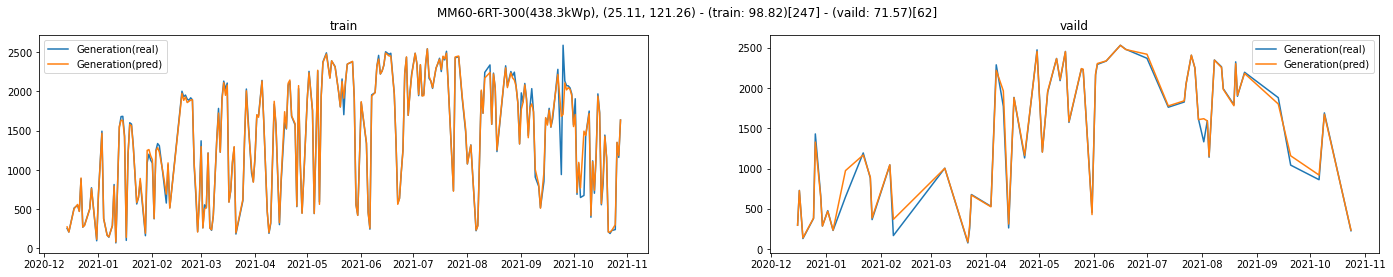

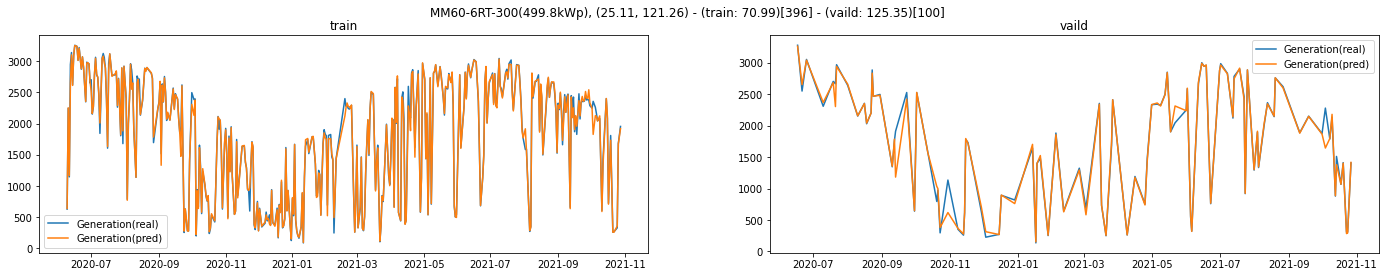

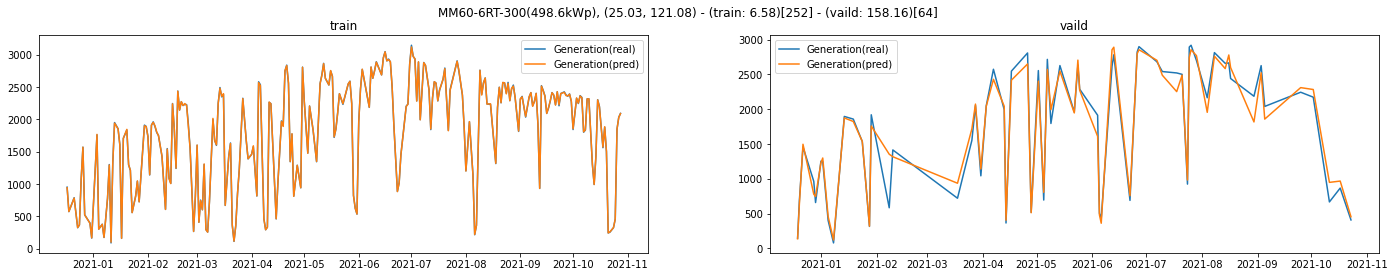

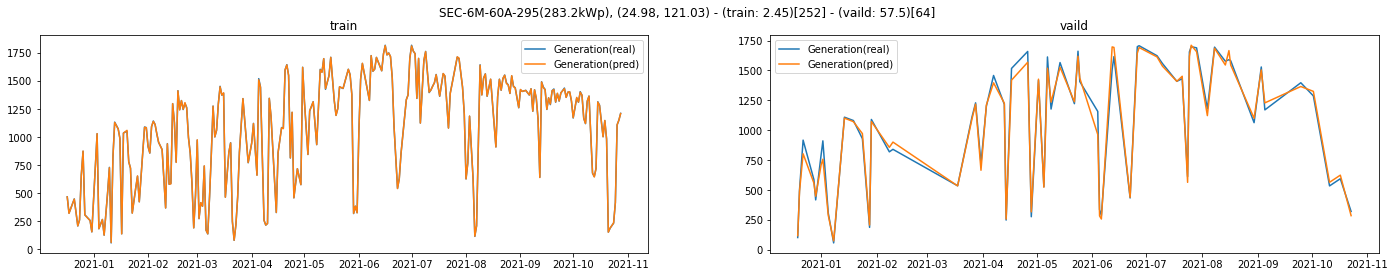

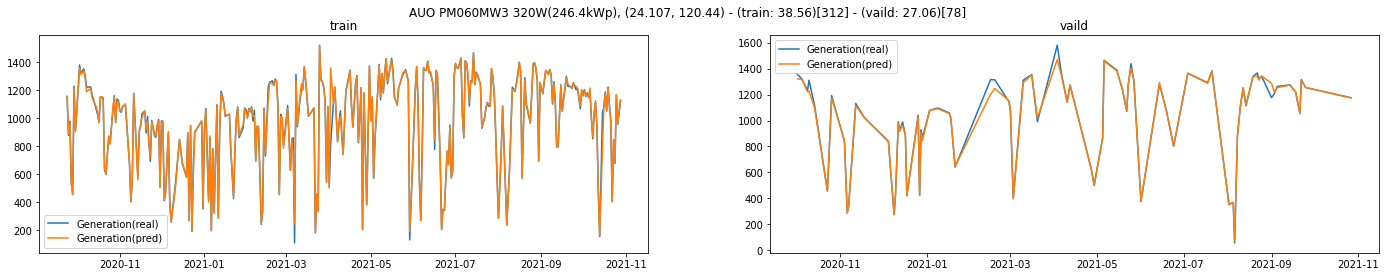

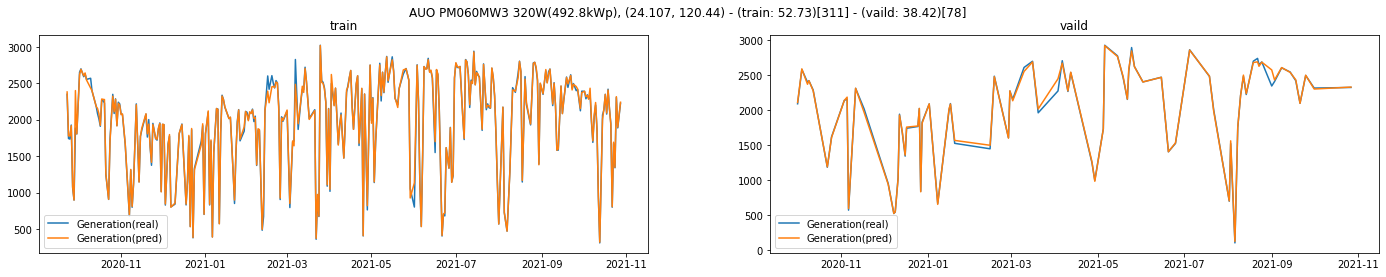

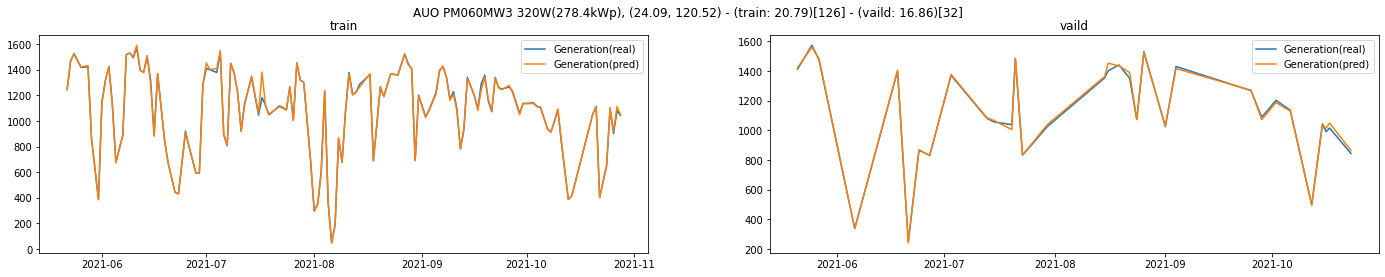

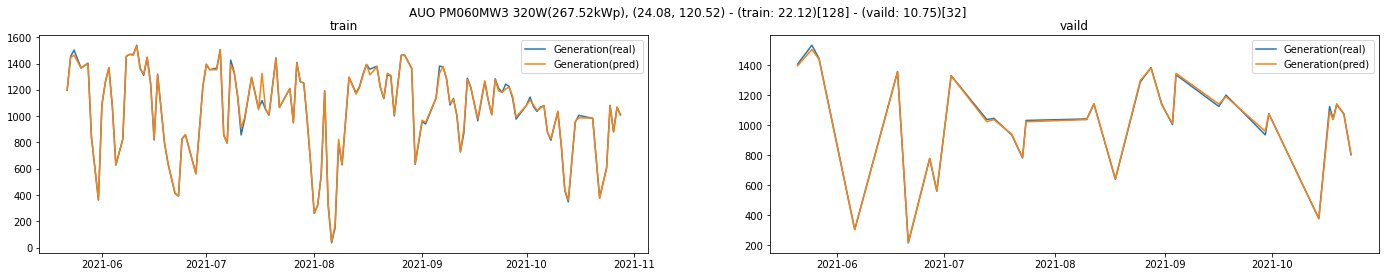

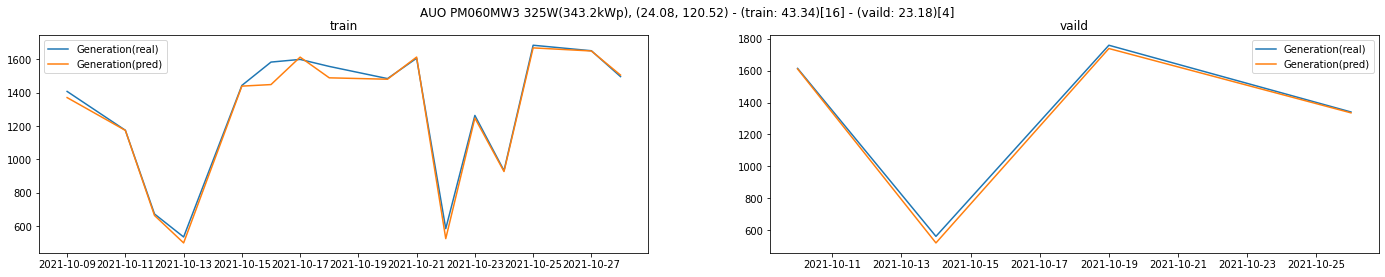

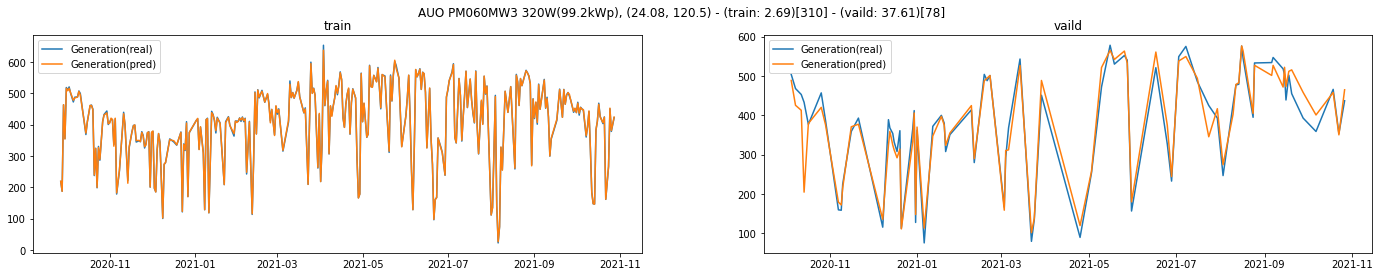

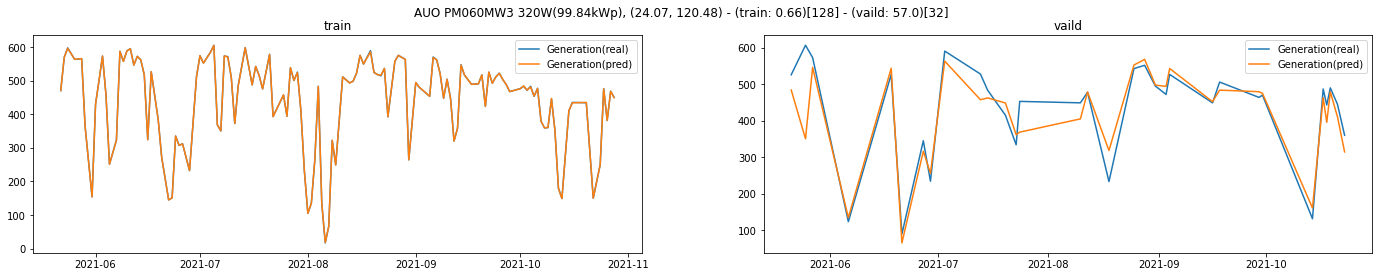

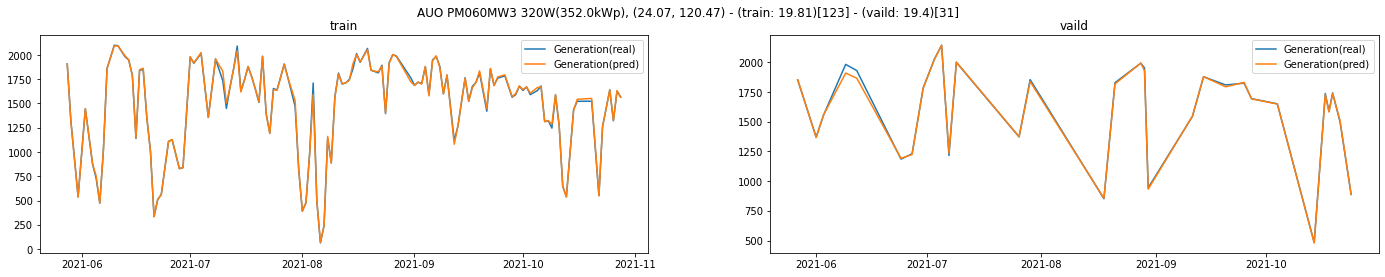

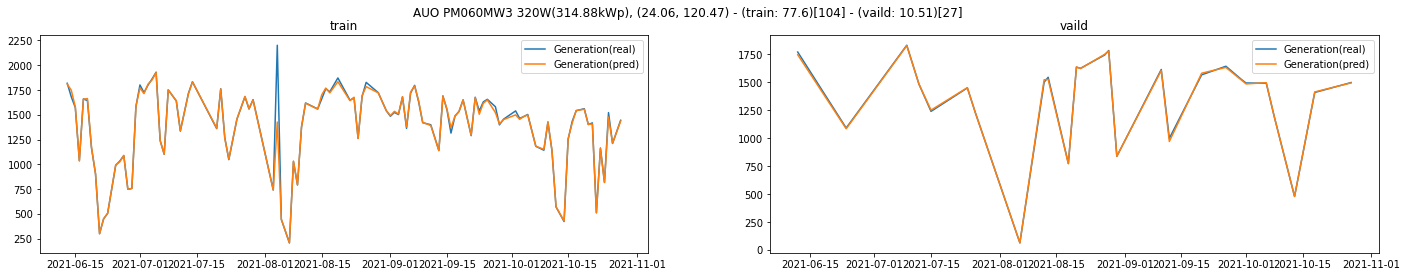

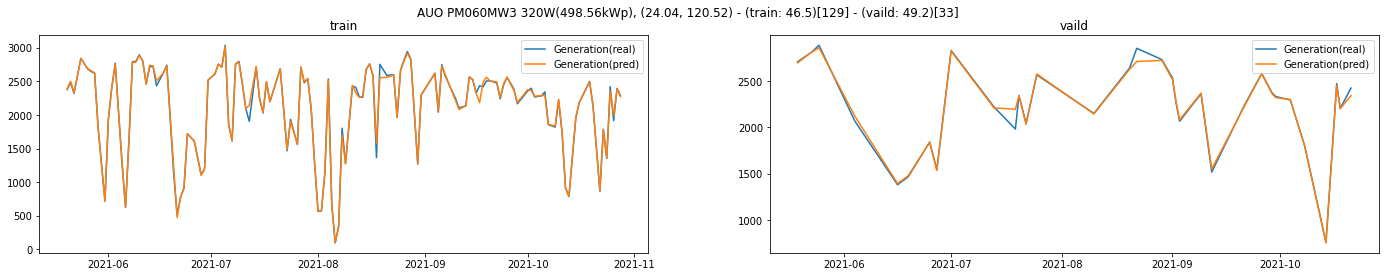

Total error 15.95 120.44


In [76]:
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    full_by_hours_idf = filter_by_module_capacity_location(full_by_hours, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    # Split vaild from train data
    train_idf, vaild_idf = train_test_split(train_idf, test_size=0.2, shuffle=True, random_state=SEED)
    train_idf = train_idf.sort_values(by=['ID'], inplace=False)
    test_idf = test_idf.sort_values(by=['ID'], inplace=False)
    vaild_idf = vaild_idf.sort_values(by=['ID'], inplace=False)
    
    train_error = round(RMSE(train_idf['Generation(kWd)'].values, train_idf['Generation(pred)'].values),2)
    vaild_error = round(RMSE(vaild_idf['Generation(kWd)'].values, vaild_idf['Generation(pred)'].values),2)
    
    plt.figure(figsize=(24, 4))
    plt.suptitle(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) - (train: {train_error})[{len(train_idf)}] - (vaild: {vaild_error})[{len(vaild_idf)}]")
    plt.subplot(1, 2, 1)
    plt.title("train")
    plt.plot(train_idf['Date'], train_idf['Generation(kWd)'], label='Generation(real)')
    plt.plot(train_idf['Date'], train_idf['Generation(pred)'], label='Generation(pred)')
    plt.legend() 
    plt.subplot(1, 2, 2)
    plt.title("vaild")
    plt.plot(vaild_idf['Date'], vaild_idf['Generation(kWd)'], label='Generation(real)')
    plt.plot(vaild_idf['Date'], vaild_idf['Generation(pred)'], label='Generation(pred)')
    plt.legend() 
    plt.show()
    
# Total error
train_error = round(RMSE(train[train['Set'].eq('train')]['Generation(kWd)'].values, train[train['Set'].eq('train')]['Generation(pred)'].values),2)
vaild_error = round(RMSE(train[train['Set'].eq('vaild')]['Generation(kWd)'].values, train[train['Set'].eq('vaild')]['Generation(pred)'].values),2)
print('Total error', train_error, vaild_error)    

## Playground

In [26]:
print(fuck)

NameError: name 'fuck' is not defined

In [ ]:
# # test
# train_group_by_lat = group_by_lat(train)
# row = train_group_by_lat.iloc[0]
# # Filter the data by module & capacity & location
# train_idf = filter_by_lat(train, row['Lat'])
# test_idf = filter_by_lat(test, row['Lat'])
# full_by_hours_idf = filter_by_lat(full_by_hours, row['Lat'])

# outliers2 = train_idf[train_idf['Date'].isin(pd.to_datetime(outliers[i]['generation']).date)].index.tolist()
# train_idf = train_idf[~(train_idf.index.isin(outliers2))].reset_index(drop=True)

# outliers2 = train_idf[train_idf['Date'].isin(pd.to_datetime(outliers[0]['generation']).date)].index.tolist()
# train_idf = train_idf[~(train_idf.index.isin(outliers2))]

# # Split vaild from train data
# train_idf, vaild_idf = train_test_split(train_idf, test_size=0.2, shuffle=True)
# train_idf = train_idf.sort_values(by=['ID'], inplace=False, ignore_index=True)
# vaild_idf = vaild_idf.sort_values(by=['ID'], inplace=False, ignore_index=True)

In [ ]:
# model = SVR(kernel='rbf').fit(train_x, train_y.reshape(-1))
# pred_train_y = model.predict(train_x).reshape(-1, 1)
# pred_vaild_y = model.predict(vaild_x).reshape(-1, 1)

# # normalized reduction
# train_y = train_y * row['Capacity']
# pred_train_y = pred_train_y * row['Capacity']
# vaild_y = vaild_y * row['Capacity']
# pred_vaild_y = pred_vaild_y * row['Capacity']

# print(round(RMSE(train_y, pred_train_y),2), round(RMSE(vaild_y, pred_vaild_y),2))

224.94 289.55


In [ ]:
# model = lgb.LGBMRegressor().fit(train_x, train_y.reshape(-1))
# # 1+7D
# # 58.66165654445877
# # 317.54787419496836
# # 1+3D
# # 67.4845331227586
# # 283.9947750434095
# # 1+0D
# # 112.61875800940963
# # 245.76228583154122


In [ ]:
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     learning_rate=0.01,
#     colsample_bytree=0.1,
#     seed=SEED,
#     subsample=0.1,
#     min_child_weight=1,
#     n_estimators=1000
# ).fit(train_x, train_y.reshape(-1))

# # pred
# pred_train_y = model.predict(train_x).reshape(-1, 1)
# pred_vaild_y = model.predict(vaild_x).reshape(-1, 1)

# # normalized reduction
# reduction_train_y = train_y * row['Capacity']
# pred_train_y = pred_train_y * row['Capacity']
# reduction_vaild_y = vaild_y * row['Capacity']
# pred_vaild_y = pred_vaild_y * row['Capacity']

# print(round(RMSE(reduction_train_y, pred_train_y),2), round(RMSE(reduction_vaild_y, pred_vaild_y),2))
# # 7D
# # 0.013448159399461668
# # 362.13862265910984
# # 3D
# # 0.005796302722998175
# # 274.6546351342357
# # 1+0D
# # 0.10929316877660708
# # 231.15511157188337
# # 1D, IDSL
# # 216.14418713233272
# # 222.27645344257954
# # 1D, IDSL(drop outlier)
# # 130.78 > 131.01
# # 271.99 > 273.81


131.01 273.81


## Submission

In [72]:
prev = pd.read_csv('submission/(lon-7)xgb-2d-drop-outlier.csv')
test['Generation(pred)'] = test['Generation(pred)']*0.5 + prev['Generation']*0.5

In [74]:
submission = test[['ID', 'Generation(pred)']].copy()
submission = submission.rename(columns={'Generation(pred)': 'Generation'})
submission.to_csv(os.path.join(path, f'submission/(esm)xgb-2d-drop-outlier.csv'), index=False)

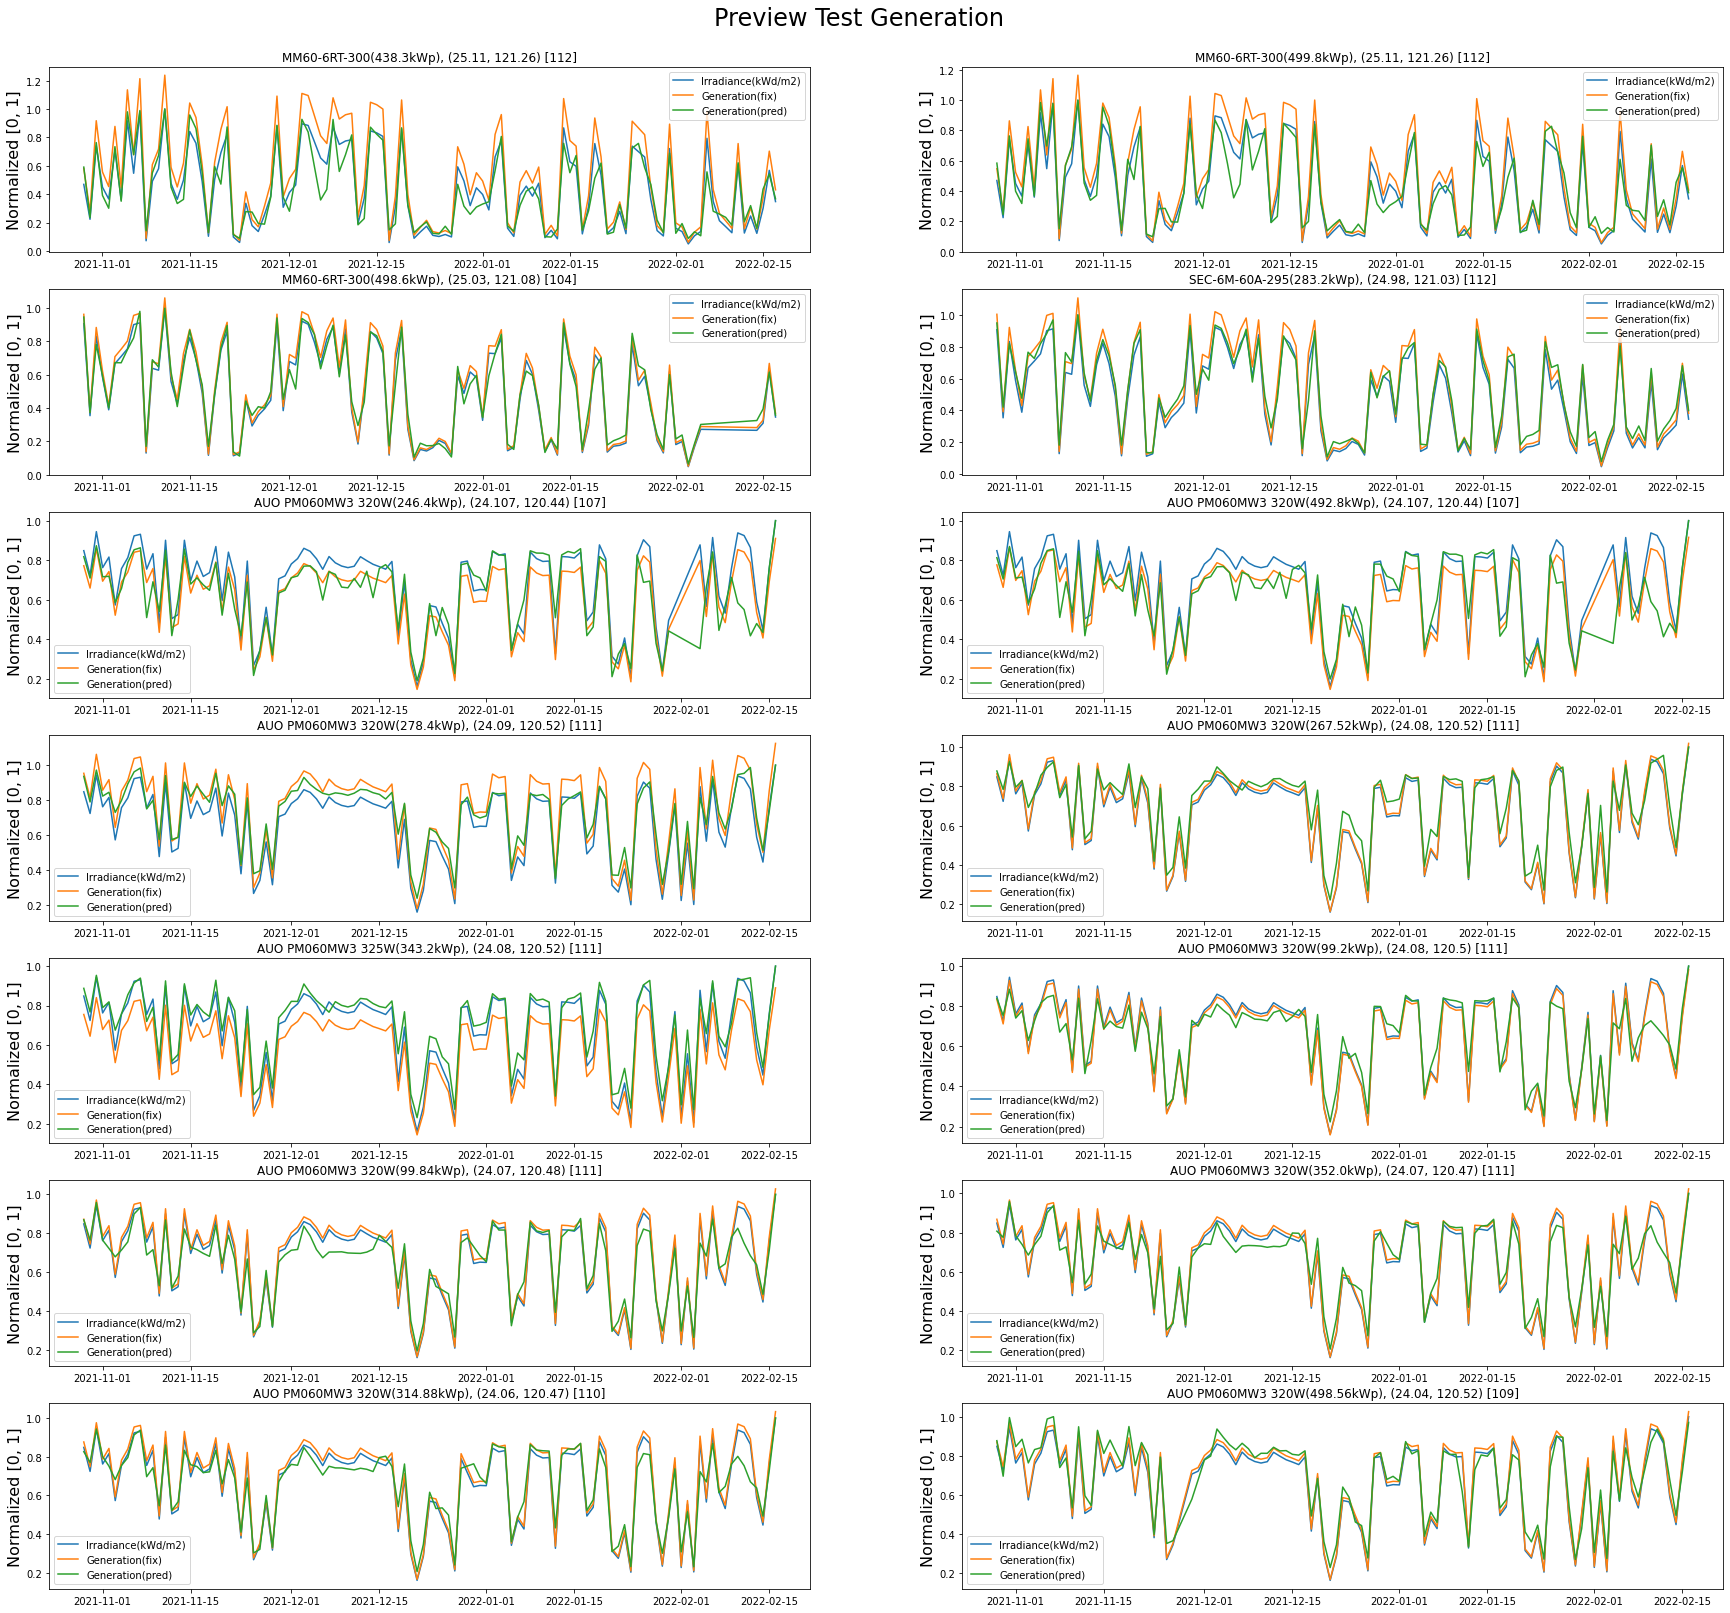

In [73]:
plt.figure(figsize=(30, 28))
plt.suptitle('Preview Test Generation', fontsize=24, y=0.91)
for i, row in train_group.iterrows():
    idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    plt.subplot(math.ceil(len(train_group)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance(kWd/m2)']/idf['Irradiance(kWd/m2)'].max(), label='Irradiance(kWd/m2)')
    plt.plot(idf['Date'], idf['Fix']/idf['Generation(pred)'].max(), label='Generation(fix)')
    plt.plot(idf['Date'], idf['Generation(pred)']/idf['Generation(pred)'].max(), label='Generation(pred)')
    # plt.ylabel('kWh/m²', fontsize=16)
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 